In [1]:
#load gamelog_data
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from pyquery import PyQuery as pq
from bs4 import BeautifulSoup
import json
import requests
import datetime

def season_subset(df, year_season_start, year_season_end = None):
    df["GAME_DATE"] = pd.to_datetime(df["GAME_DATE"])
    if year_season_end is None:
        year_season_end = year_season_start + 1
    df_gt = df[df.GAME_DATE > datetime.date(year_season_start,9,1)]
    df_lt = df_gt[df_gt.GAME_DATE < datetime.date(year_season_end,9,1)]
    return df_lt.sort_values("GAME_DATE") if not df_lt.empty else None

In [2]:
post85df = pd.read_csv('./gamelogs/master_post86df.csv')
post85df = post85df.drop('VIDEO_AVAILABLE',1)
df85_15 = season_subset(post85df,1985,2015)

by_player = df85_15.groupby("PLAYER_NAME")

In [3]:
df85_15["FANTASY_ZSCORE"] = by_player["FANTASY_PTS"].apply(lambda x: ((x - x.mean())/x.std()))
df85_15["i_ZSCORE_OVER"] = df85_15["FANTASY_ZSCORE"].map(lambda x: 1 if x > 1 else 0)
df85_15["SEASON_MIN"] = by_player['MIN'].apply(lambda x: x.map(lambda y: x.sum()))
df85_15["GAMES_PLAYED"] = by_player["PLAYER_NAME"].apply(lambda x: x.map(lambda y: len(x)))
for x in ['FG_PCT', 'FG3_PCT', 'FT_PCT']:
    df85_15[x] = df85_15[x].map(lambda y: 0 if np.isnan(y) else y)
df85_15["WL"] = [1 if v == "W" else 0 for v in df85_15.copy()["WL"]]

opp_home = df85_15.MATCHUP.map(lambda x: (x[-3:],0) if "@" in x else (x[-3:],1))
df85_15["OPP"] = opp_home.map(lambda x: x[0])
df85_15["i_HOME"] = opp_home.map(lambda x: x[1])

In [4]:
#Add player bio data for age,weight,height
player_bios_df = pd.read_csv("./player_bios/player_bios.csv")
player_bios_df = player_bios_df.rename(columns = {'PERSON_ID': 'PLAYER_ID', 'DISPLAY_FIRST_LAST': 'PLAYER_NAME'})
player_bios_df["BIRTHDATE"] = pd.to_datetime(player_bios_df["BIRTHDATE"])
player_bios_df['AGE'] = player_bios_df["BIRTHDATE"].map(lambda x: round((pd.to_datetime('today') - x).days / 365.,2))
player_bios_df["WEIGHT"] = player_bios_df["WEIGHT"].astype('str')
player_bios_df["HEIGHT"] = player_bios_df["HEIGHT"].astype('str')
player_bios_df["WEIGHT"] = player_bios_df["WEIGHT"].map(lambda x:  float(x) if x != 'nan' else 0.)
player_bios_df["HEIGHT"] = player_bios_df["HEIGHT"].map(lambda x: (12.*float(x[0]) + float(x[2:])) if x != 'nan' else 0.)

by_player = df85_15.groupby("PLAYER_NAME")

In [5]:
def get_player_bio(name, col_name):
    return float(player_bios_df[player_bios_df.PLAYER_NAME == name][col_name])

df85_15["AGE"] = by_player["PLAYER_NAME"].apply(lambda x: x.replace(x.iloc[0],get_player_bio(x.iloc[0],"AGE")))
df85_15["WEIGHT"] = by_player["PLAYER_NAME"].apply(lambda x: x.replace(x.iloc[0],get_player_bio(x.iloc[0],"WEIGHT")))
df85_15["HEIGHT"] = by_player["PLAYER_NAME"].apply(lambda x: x.replace(x.iloc[0],get_player_bio(x.iloc[0],"HEIGHT")))

In [6]:
#Integrate ELO Rankings
elo_df = pd.read_csv("./gamelogs/all_elo.csv")
elo_df["date_game"] = pd.to_datetime(elo_df["date_game"])
elo_df["game_location"] = elo_df["game_location"].map(lambda x: 1 if x == "H" else 0)
elo_df = elo_df[elo_df["is_playoffs"] == 0]

curr = elo_df.columns.tolist()
cols = [curr[i] for i in [5,8,11,13,14,17,19,21]]
elo_df = elo_df[cols]
elo_df = elo_df.rename(columns={'date_game': 'GAME_DATE',
                                'team_id':'TEAM_ABBREVIATION',
                                'opp_id':'OPP', 
                                'game_location': 'i_HOME',
                                'elo_i':'ELO',
                                'opp_elo_i': 'OPP_ELO',
                                'win_equiv': 'EXP_WINS',
                                'forecast':'FORECAST'})

df85_15 = df85_15.merge(season_subset(elo_df,1985,2015))

In [7]:
#Rearrange some columns in df85_15
curr = df85_15.columns.tolist()
cols = curr[:3] + curr[32:37] + curr[3:9] + curr[37:] + curr[9:32]
if len(curr) == len(cols):
    df85_15 = df85_15[cols]


name_pos = player_bios_df[["PLAYER_ID","POSITION","PLAYER_NAME"]]
df85_15 = df85_15.merge(name_pos)
df85_15.columns.tolist()

['SEASON_ID',
 'PLAYER_ID',
 'PLAYER_NAME',
 'SEASON_MIN',
 'GAMES_PLAYED',
 'OPP',
 'i_HOME',
 'AGE',
 'TEAM_ABBREVIATION',
 'TEAM_NAME',
 'GAME_ID',
 'GAME_DATE',
 'MATCHUP',
 'WL',
 'WEIGHT',
 'HEIGHT',
 'ELO',
 'EXP_WINS',
 'OPP_ELO',
 'FORECAST',
 'MIN',
 'FGM',
 'FGA',
 'FG_PCT',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'PF',
 'PTS',
 'PLUS_MINUS',
 'FANTASY_PTS',
 'FANTASY_ZSCORE',
 'i_ZSCORE_OVER',
 'POSITION']

In [8]:
def calc_season_avg(df,col_list,(date_str1,date_str2)):
    date1, date2 = pd.to_datetime(date_str1), pd.to_datetime(date_str2)
    mask = lambda x: (date1 <= x) & (x <= date2)
    return df[df.GAME_DATE.apply(mask)].groupby(["PLAYER_NAME","SEASON_ID"])[col_list].mean().reset_index()

In [9]:
def ngames_colname(col_list, ngames):
    return map(lambda x: str(ngames) + 'D_' + x, col_list)

In [10]:
def last_ngames(df,ngames,game_date,col_list):
    ngames_df = df[df.GAME_DATE < game_date].nlargest(ngames, "GAME_DATE")
    ngames_col_list = ngames_colname(col_list,ngames)
    num_cols = len(ngames_col_list)
    date_player_tuples = [("GAME_DATE",game_date)]#,("PLAYER_NAME",df.PLAYER_NAME.iloc[0])]
    if ngames_df.empty:
        return dict(date_player_tuples + zip(ngames_col_list,np.array(0).repeat(num_cols)))
    else:
        return dict(date_player_tuples + zip(ngames_col_list,ngames_df[col_list].mean()))

In [11]:
def calc_ngame_avg(df,col_list,game_date_str,ngames):
    game_date = pd.to_datetime(game_date_str)
    season_id = df[df.GAME_DATE == game_date]["SEASON_ID"].iloc[0]
    return last_ngames(df[df.SEASON_ID == season_id],ngames,game_date,col_list)

In [12]:
def rolling_cols(df,col_list,ngames,rolling_kind):
    if rolling_kind == 'mean':
        rolling_func = lambda (a,b,c): pd.rolling_mean(a,b,min_periods = c)
    elif rolling_kind == 'sum':
        rolling_func = lambda (a,b,c): pd.rolling_sum(a,b,min_periods = c)
    else:
        return None 
    
    rolling_df = (df.groupby(["PLAYER_NAME","SEASON_ID"])
                    .apply(lambda x: add_game_date_pts_col(rolling_func((x[col_list],ngames,1)),x.GAME_DATE,x.FANTASY_PTS).reset_index(drop = True)))
    return rolling_df.reset_index().drop('level_2',axis = 1).rename(columns=dict(zip(col_list,map(lambda x: 'R_' + x,col_list))))

In [13]:
def add_game_date_pts_col(df,game_date_col,fantasy_pts_col):
   new_df = pd.concat([df,game_date_col], axis = 1)
   return new_df

In [14]:
def per_season_cumsum(df,col_list):
    cumsum_df = (df.groupby(["PLAYER_NAME","SEASON_ID"])
                   .apply(lambda x: add_game_date_col(x[col_list].cumsum(axis = 0), x.GAME_DATE).reset_index(drop = True)))
    return cumsum_df.reset_index().drop('level_2',axis = 1).rename(columns=dict(zip(col_list,map(lambda x: 'C_' + x,col_list))))

In [15]:
def per_season_cummean(df,col_list):
    cumsum_df = (df.groupby(["PLAYER_NAME","SEASON_ID"])
                   .apply(lambda x: add_game_date_pts_col(pd.expanding_mean(x[col_list], min_periods = 2), x.GAME_DATE, x.FANTASY_PTS).reset_index(drop = True)))
    return cumsum_df.reset_index().drop('level_2',axis = 1).rename(columns=dict(zip(col_list,map(lambda x: 'C_' + x,col_list))))

In [16]:
def enumerate_games(df):
    new_df = df.copy()
    new_df["GAME_NUM"] = range(1,len(df.GAME_DATE) + 1)
    return new_df

def sigmoidfun(x):
	return 1/(1+np.exp(-0.007*(x-800)))

def fantasy_avg_lastn(player_df,last_n_seasons,seasons):
    return player_df[[s in seasons[-last_n_seasons:] for s in player_df.SEASON_ID]]['FANTASY_PTS'].mean()    

def true_fantasy_mean(player_df,last_n_seasons):
    seasons = list(set(player_df.SEASON_ID))
    lastn_mean = fantasy_avg_lastn(player_df,last_n_seasons,seasons)
    return player_df.groupby("SEASON_ID").apply(lambda x: x.apply(lambda y: lastn_mean + sigmoidfun(y.MIN) * (y.C_FANTASY_PTS - lastn_mean),axis = 1))

def fantasy_resp(df):
    return df.groupby('PLAYER_NAME').apply(lambda x: true_fantasy_mean(x,5))

In [107]:
ewma_pos = df85_15.groupby(["OPP",'SEASON_ID',"POSITION"]).apply(lambda x: np.log(pd.ewma(x.PTS,span = 3).shift(1) + 1)).reset_index().rename(columns={'PTS':'EWMA_OPP_POS', 'level_3':'OLD_INDEX'}).set_index('OLD_INDEX')
cols_touse = ewma_pos.columns.difference(df85_15.columns)
ewma_pos_df = pd.merge(df85_15,ewma_pos[cols_touse], left_index = True, right_index = True, how = 'outer').dropna()

In [216]:
def get_player_seasons(player_name, season1,season2,full_df,ewma_colresp, ewma_colfeat):
    player_df = full_df[full_df.PLAYER_NAME == player_name].copy()
    player_df['SHIT'] = player_df['OPP_ELO'].map(lambda x: 1 if x < 1400 else 0)
    player_df['OKAY'] = player_df['OPP_ELO'].map(lambda x: 1 if 1400 <= x < 1600 else 0)
    player_df['GOOD'] = player_df['OPP_ELO'].map(lambda x: 1 if 1600 <= x < 1700 else 0)
    player_df['GREAT'] = player_df['OPP_ELO'].map(lambda x: 1 if 1700 <= x else 0)
    player_df2 = pd.concat([player_df.reset_index(drop = True),player_df.groupby("SEASON_ID").apply(lambda x: np.log(pd.ewma(x[ewma_colresp], span = 3).shift(1) + 1).reset_index().drop('index',axis=1).rename(columns={ewma_colresp:'EWMA_LOG_' + ewma_colresp})).reset_index(drop = True)],axis = 1)
    for ewma_col in ewma_colfeat:
        player_df2['EWMA_LOG_' + ewma_col] = player_df2.groupby("SEASON_ID").apply(lambda x: np.log(pd.ewma(x[ewma_col], span = 3).shift(1) + 1).reset_index().drop('index',axis=1).rename(columns={ewma_col:'EWMA_LOG_' + ewma_col})).reset_index(drop = True)
    resp = player_df2.groupby('SEASON_ID').apply(lambda x: x.apply(lambda y: 1 if np.log(y[ewma_colresp] + 1) > 1.05* y['EWMA_LOG_' + ewma_colresp] else 0, axis = 1).reset_index().drop('index',axis=1).rename(columns={0: ewma_colresp + '_RESP'})).reset_index(drop = True)
    player_df3 = pd.concat([player_df2,resp], axis = 1)
    fst_season = season1 + 20000
    lst_season = season2 + 20000
    player_df_final = player_df3[(player_df3.SEASON_ID <= lst_season) & (player_df3.SEASON_ID >= fst_season)].dropna()
    return player_df_final, np.array(player_df_final.SEASON_ID < lst_season)

In [223]:
ewma_colresp = 'FANTASY_PTS'
ewma_colfeats =['PTS','AST']
df,mask = get_player_seasons("Kobe Bryant",2003,2009,ewma_pos_df,ewma_colresp,ewma_colfeats)

In [96]:
mask.shape,mask.sum()

((582,), 532)

In [193]:
df['EWMA_LOG_PTS'] * 2

318    6.802395
319    7.203736
320    7.275172
321    6.453688
322    6.603586
323    6.776835
324    6.789756
325    6.657113
326    6.550224
327    6.644621
328    6.581407
329    6.830973
330    6.849561
331    6.426327
332    6.220685
333    6.289543
334    6.002152
335    6.275643
336    6.518254
337    6.592666
338    6.931891
339    6.227328
340    6.884146
341    6.743251
342    6.276452
343    6.518612
344    6.735676
345    6.438381
346    6.700084
347    6.535482
         ...   
874    6.868690
875    6.931818
876    6.397572
877    6.717372
878    6.387173
879    6.371701
880    6.741059
881    6.317994
882    6.853307
883    6.656303
884    6.266058
885    6.353747
886    6.515104
887    6.553755
888    6.572804
889    6.506418
890    6.130201
891    5.911727
892    5.900335
893    6.094236
894    6.770630
895    6.819894
896    6.777698
897    6.501982
898    6.621667
899    6.373034
900    6.445894
901    6.441827
902    6.701597
903    6.683089
Name: EWMA_LOG_PTS, dtyp

In [68]:
np.isinf(df[STANDARDIZABLE[1]].values[mask]).sum()

0

In [64]:
STANDARDIZABLE[1]

'EWMA_OPP_POS'

In [225]:
from sklearn.cross_validation import train_test_split
#train_test_split(xrange(df.shape[0]), train_size=0.7)

dftouse = df.copy()

ewma_feats = map(lambda x: 'EWMA_LOG_' + x , ewma_colfeats)
STANDARDIZABLE = ['EWMA_LOG_' + ewma_colresp, 'EWMA_OPP_POS'] + ewma_feats

from sklearn.preprocessing import StandardScaler
for col in STANDARDIZABLE:
    print col
    valstrain=df[col].values[mask]
    valstest=df[col].values[~mask]
    scaler=StandardScaler().fit(valstrain)
    outtrain=scaler.transform(valstrain)
    outtest=scaler.fit_transform(valstest)
    out=np.empty(mask.shape[0])
    out[mask]=outtrain
    out[~mask]=outtest
    dftouse[col]=out

lcols = STANDARDIZABLE + ["OKAY","GOOD","GREAT"]

from sklearn.svm import LinearSVC
clfsvm = LinearSVC(C=.01)
#cs=[.0001,.001,.01,.1,1,10]
#n_estimators = [1,2,10,100,500,1000]
#max_depth = [2,3,5,7,10]
Xmatrix=dftouse[lcols].values
Yresp=dftouse[ewma_colresp + '_RESP'].values 
Xmatrix_train=Xmatrix[mask]
Xmatrix_test=Xmatrix[~mask]
Yresp_train=Yresp[mask]
Yresp_test=Yresp[~mask]

#your code here
# from sklearn.grid_search import GridSearchCV
# #{'n_estimators':n_estimators,'max_depth':max_depth}
# gs=GridSearchCV(clfsvm, param_grid={'C':cs}, cv=5)
# gs.fit(Xmatrix_train, Yresp_train)
# print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_

# #calculate the accuracy here
# best = gs.best_estimator_
# best.fit(Xmatrix_train, Yresp_train)
# best.score(Xmatrix_test, Yresp_test)
clfsvm.fit(Xmatrix_train, Yresp_train)
clfsvm.score(Xmatrix_test, Yresp_test)

EWMA_LOG_FANTASY_PTS
EWMA_OPP_POS
EWMA_LOG_PTS
EWMA_LOG_AST


0.72499999999999998

In [212]:
lcols

['EWMA_LOG_FANTASY_PTS',
 'EWMA_OPP_POS',
 'EWMA_LOG_PTS',
 'EWMA_LOG_AST',
 'OKAY',
 'GOOD',
 'GREAT']

In [282]:
season_subset(df85_15,2014).groupby('PLAYER_NAME').apply(lambda x: map(lambda y: (x.loc[x.index.tolist()[y+1]].GAME_DATE - x.loc[x.index.tolist()[y]].GAME_DATE).days,range(x.shape[0] - 1)).reset_index())

,PLAYER_NAME,0
0,A.J. Price,"[1, 2, 2, 2, 1, 9, 2, 8, 7, 6, 6, 3, 2, 2, 1, ..."
1,Aaron Brooks,"[2, 1, 3, 1, 2, 1, 2, 3, 2, 2, 3, 1, 3, 1, 3, ..."
2,Aaron Gordon,"[2, 2, 3, 1, 2, 4, 1, 2, 1, 64, 3, 2, 2, 1, 3,..."
3,Adreian Payne,"[18, 1, 40, 2, 2, 1, 2, 2, 3, 2, 4, 2, 3, 1, 4..."
4,Al Horford,"[3, 4, 3, 2, 2, 2, 1, 3, 3, 4, 1, 2, 4, 1, 4, ..."
5,Al-Farouq Aminu,"[2, 2, 2, 3, 1, 2, 2, 2, 2, 4, 2, 1, 2, 2, 2, ..."
6,Alec Burks,"[1, 4, 2, 2, 2, 1, 2, 2, 1, 3, 3, 1, 2, 2, 3, ..."
7,Alex Kirk,"[6, 19, 32, 4]"
8,Alexey Shved,"[2, 1, 2, 2, 2, 2, 8, 5, 2, 5, 2, 9, 3, 2, 7, ..."
9,Alexis Ajinca,"[6, 5, 4, 2, 3, 1, 3, 1, 7, 3, 4, 1, 2, 3, 8, ..."


In [263]:
merged_df = pd.merge(df85_15,df85_15.groupby(["PLAYER_NAME",'OPP']).apply(lambda x: x.FANTASY_PTS).reset_index().rename(columns = {0:"FANTASY_PTS_AGAINST"}), left_on=['PLAYER_NAME','OPP'],right_on=['PLAYER_NAME','OPP'])

In [17]:
merged_df = pd.merge(df85_15,per_season_cummean(df85_15,['FANTASY_PTS']))

In [19]:
true_mean_df = merged_df.groupby(['PLAYER_NAME','SEASON_ID']).apply(lambda x: x.apply(lambda y: fantasy_avg_lastn(x,5,list(set(x.SEASON_ID))) + sigmoidfun(y.MIN) * (y.C_FANTASY_PTS - fantasy_avg_lastn(x,5,list(set(x.SEASON_ID)))), axis = 1))

In [46]:
;

''

In [20]:
merged_true_mean = pd.merge(df85_15,true_mean_df.reset_index().set_index('level_2'))

In [21]:
merged_true_mean = merged_true_mean.rename(columns={0:'TRUE_FANTASY_AVG'})

In [ ]:
true_mean_df85_15 = true_mean_df.reset_index().rename(columns={0:'TRUE_FANTASY_AVG'}).set_index('level_2')
del true_mean_df85_15.index.name

In [35]:
true_mean_df85_15.to_csv('./true_mean_df85_152.csv', index = False)

In [27]:
df85_15.shape

(550709, 44)

In [49]:
check_df = pd.read_csv('./true_mean_df85_152.csv')

In [19]:
test_df = season_subset(df85_15,2006,2010)
kobe_df = test_df[test_df.PLAYER_NAME == "Kobe Bryant"]
kobe_df = kobe_df.groupby("SEASON_ID").apply(lambda x: enumerate_games(x).reset_index(drop = True)).reset_index(drop = True)

(0, 79)

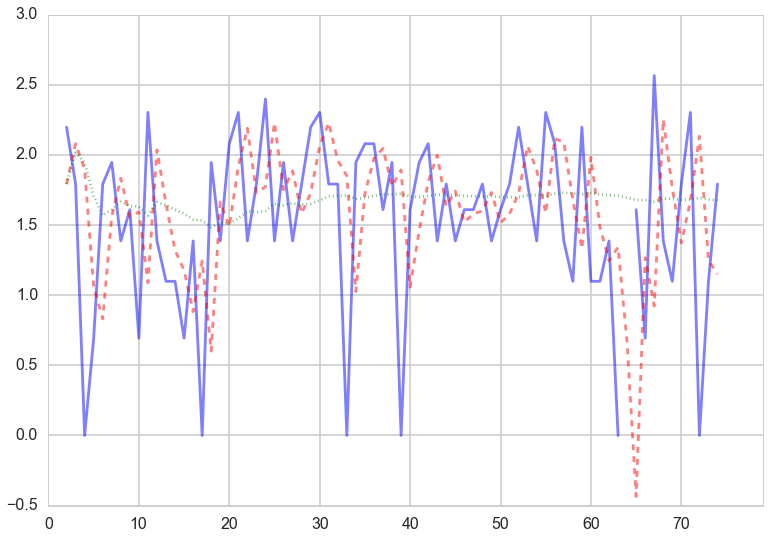

In [312]:
fig = plt.figure()
ax = plt.axes()
season = map(lambda x: 20000 + x, [2006,2007,2008,2009])
ax.plot(kobe_df[kobe_df.SEASON_ID == season[0]]['GAME_NUM'][1:], np.log(kobe_df[kobe_df.SEASON_ID == season[0]]['AST'][1:]), linestyle='-', color ='b', alpha = 0.5)
ax.plot(kobe_df[kobe_df.SEASON_ID == season[0]]['GAME_NUM'], np.log(pd.ewma(kobe_df[kobe_df.SEASON_ID == season[0]]['AST'], span = 2, adjust = False).shift(1)), linestyle='--', color ='r', alpha = 0.5)
ax.plot(kobe_df[kobe_df.SEASON_ID == season[0]]['GAME_NUM'], np.log(pd.expanding_mean(kobe_df[kobe_df.SEASON_ID == season[0]]['AST']).shift(1)), linestyle=':', color ='g', alpha = 0.5)
#ax.plot(kobe_df[kobe_df.SEASON_ID == season[3]]['GAME_NUM'], np.log(kobe_df[kobe_df.SEASON_ID == season[3]]['PTS']), linestyle='-.', color ='k', alpha = 0.5)
ax.set_xlim(min(kobe_df['GAME_NUM']) - 1, max(kobe_df['GAME_NUM']) + 1)


In [328]:
;

''

In [329]:
;

''

In [251]:
pd.merge(kobe_df,kobe_df.groupby("SEASON_ID").apply(lambda x: np.log(pd.ewma(x['PTS'], span = 3).shift(1)).reset_index().drop('index',axis=1).rename(columns={'PTS':'EWMA_LOG_PTS'})).reset_index(drop = True), left_index = True, right_index = True)

,SEASON_ID,PLAYER_ID,PLAYER_NAME,SEASON_MIN,GAMES_PLAYED,OPP,i_HOME,AGE,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,WEIGHT,HEIGHT,ELO,EXP_WINS,OPP_ELO,FORECAST,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,FANTASY_PTS,FANTASY_ZSCORE,i_ZSCORE_OVER,POSITION,GAME_NUM,EWMA_LOG_PTS
0,22008,977,Kobe Bryant,46780,1280,POR,1,37.31,LAL,Los Angeles Lakers,20800003,2008-10-28,LAL vs. POR,1,212,78,1651.7117,56.347404,1472.9480,0.832673,33,9,17,0.529,1,1,1.000,4,5,0.800,2,9,11,5,1,0,5,3,23,17,44.25,0.136712,0,Forward-Guard,1,NaN
1,22008,977,Kobe Bryant,46780,1280,LAC,0,37.31,LAL,Los Angeles Lakers,20800015,2008-10-29,LAL @ LAC,1,212,78,1656.1938,57.341938,1362.9255,0.752603,31,5,12,0.417,0,2,0.000,6,7,0.857,2,6,8,3,2,0,5,2,16,23,32.00,-0.703768,0,Forward-Guard,2,3.135494
2,22008,977,Kobe Bryant,46780,1280,DEN,0,37.31,LAL,Los Angeles Lakers,20800037,2008-11-01,LAL @ DEN,1,212,78,1667.3407,58.082809,1569.2125,0.497306,33,11,24,0.458,1,2,0.500,10,12,0.833,3,1,4,3,2,0,1,4,33,13,46.50,0.291086,0,Forward-Guard,3,2.908721
3,22008,977,Kobe Bryant,46780,1280,LAC,1,37.31,LAL,Los Angeles Lakers,20800063,2008-11-05,LAL vs. LAC,1,212,78,1675.8115,58.227047,1336.7133,0.926058,36,8,21,0.381,0,2,0.000,11,14,0.786,1,1,2,3,2,2,2,3,27,15,41.00,-0.086272,0,Forward-Guard,4,3.285198
4,22008,977,Kobe Bryant,46780,1280,HOU,1,37.31,LAL,Los Angeles Lakers,20800092,2008-11-09,LAL vs. HOU,1,212,78,1677.4784,59.135544,1614.9689,0.718186,33,10,17,0.588,1,2,0.500,2,4,0.500,2,1,3,3,2,2,4,3,23,10,37.75,-0.309257,0,Forward-Guard,5,3.290886
5,22008,977,Kobe Bryant,46780,1280,DAL,0,37.31,LAL,Los Angeles Lakers,20800102,2008-11-11,LAL @ DAL,1,212,78,1688.1191,59.723694,1541.4489,0.566763,36,10,20,0.500,0,2,0.000,7,8,0.875,1,3,4,1,1,0,1,1,27,-6,35.00,-0.497936,0,Forward-Guard,6,3.213701
6,22008,977,Kobe Bryant,46780,1280,NOH,0,37.31,LAL,Los Angeles Lakers,20800112,2008-11-12,LAL @ NOH,1,212,78,1695.1462,60.489597,1624.0886,0.458445,38,5,15,0.333,1,1,1.000,9,9,1.000,0,4,4,6,0,0,2,4,20,4,33.50,-0.600852,0,Forward-Guard,7,3.256263
7,22008,977,Kobe Bryant,46780,1280,DET,1,37.31,LAL,Los Angeles Lakers,20800131,2008-11-14,LAL vs. DET,0,212,78,1704.4741,58.917793,1625.7979,0.736633,39,12,30,0.400,2,7,0.286,3,4,0.750,0,5,5,6,4,1,3,5,29,-1,53.75,0.788512,0,Forward-Guard,8,3.133438
8,22008,977,Kobe Bryant,46780,1280,CHI,1,37.31,LAL,Los Angeles Lakers,20800158,2008-11-18,LAL vs. CHI,1,212,78,1685.5458,59.075985,1468.9532,0.860860,31,9,18,0.500,3,6,0.500,0,0,0.000,1,4,5,6,3,2,1,3,21,22,47.25,0.342544,0,Forward-Guard,9,3.257644
9,22008,977,Kobe Bryant,46780,1280,DEN,1,37.31,LAL,Los Angeles Lakers,20800183,2008-11-21,LAL vs. DEN,1,212,78,1700.5847,60.600250,1597.8591,0.762599,30,12,18,0.667,1,3,0.333,4,5,0.800,2,2,4,2,2,0,1,3,29,13,41.00,-0.086272,0,Forward-Guard,10,3.156542


In [246]:
kobe_df.shape

(147, 45)

In [317]:
all(kobe_df.FANTASY_PTS > 0)

True

In [225]:
np.log(23) > float('nan')

False

In [73]:
ewma_pos = test_df.groupby(["OPP",'SEASON_ID',"POSITION"]).apply(lambda x: np.log(pd.ewma(x.PTS,span = 3).shift(1))).reset_index().rename(columns={'PTS':'EWMA_OPP_POS', 'level_3':'OLD_INDEX'}).set_index('OLD_INDEX')
cols_touse = ewma_pos.columns.difference(test_df.columns)
pd.merge(test_df,ewma_pos[cols_touse], left_index = True, right_index = True, how = 'outer')

In [88]:
list(set(test_df.columns.tolist() + ewma_pos.columns.tolist()))

['EXP_WINS',
 'MIN',
 'AGE',
 'WL',
 'TOV',
 'REB',
 'FANTASY_ZSCORE',
 'PLAYER_ID',
 'TEAM_NAME',
 'i_HOME',
 'FG3A',
 'DREB',
 'PLAYER_NAME',
 'AST',
 'TEAM_ABBREVIATION',
 'FG3M',
 'OREB',
 'FGM',
 'PF',
 'POSITION',
 'PTS',
 'FGA',
 'OPP_ELO',
 'ELO',
 'WEIGHT',
 'PLUS_MINUS',
 'STL',
 'SEASON_MIN',
 'HEIGHT',
 'SEASON_ID',
 'i_ZSCORE_OVER',
 'BLK',
 'GAME_ID',
 'MATCHUP',
 'FTM',
 'FT_PCT',
 'FTA',
 'OPP',
 'FG_PCT',
 'FORECAST',
 'FG3_PCT',
 'EWMA_OPP_POS',
 'GAME_DATE',
 'GAMES_PLAYED',
 'FANTASY_PTS']